<a href="https://colab.research.google.com/github/FatherOfLove/AdvancedDeepLearning/blob/master/Assignment2_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0


     |████████████████████████████████| 86.3MB 63kB/s 
     |████████████████████████████████| 3.8MB 44.9MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 450kB 37.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=72cfd3426e0c82844aa6fd99e460c4b7b80c9b691ee6f234a5dd9da384c83290
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tenso

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
import os
import datetime
import copy
import re
import yaml
import uuid
import warnings
import time
import inspect

import numpy as np
import pandas as pd
from functools import partial, reduce
from random import shuffle
import random

In [4]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

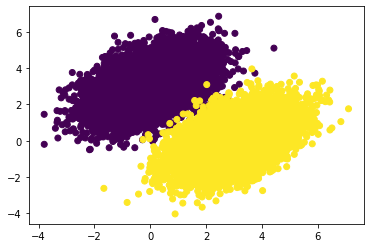

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

In [6]:
# Shuffle the data.
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.0583
Epoch 1: last batch loss = 0.0635
Epoch 2: last batch loss = 0.0460
Epoch 3: last batch loss = 0.0230
Epoch 4: last batch loss = 0.0328
Epoch 5: last batch loss = 0.0381
Epoch 6: last batch loss = 0.0238
Epoch 7: last batch loss = 0.0299
Epoch 8: last batch loss = 0.0232
Epoch 9: last batch loss = 0.0218


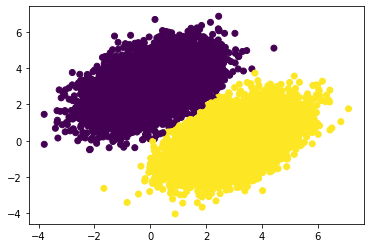

In [7]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

In [8]:
import time

t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Time per epoch: 0.141 s


In [9]:
@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Time per epoch: 0.082 s


Keras API

In [10]:
from tensorflow.keras.layers import Layer

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32, input_dim=32):
      super(Linear, self).__init__()
      w_init = tf.random_normal_initializer()
      self.w = tf.Variable(
          initial_value=w_init(shape=(input_dim, units), dtype='float32'),
          trainable=True)
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value=b_init(shape=(units,), dtype='float32'),
          trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

# Instantiate our layer.
linear_layer = Linear(4, 2)

In [11]:
y = linear_layer(tf.ones((2, 2)))
assert y.shape == (2, 4)

In [12]:
assert linear_layer.weights == [linear_layer.w, linear_layer.b]

In [13]:
class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b


# Instantiate our lazy layer.
linear_layer = Linear(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(tf.ones((2, 2)))
assert len(linear_layer.weights) == 2

In [14]:
from tensorflow.keras.layers import Layer

class ComputeSum(Layer):
  """Returns the sum of the inputs."""

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = tf.Variable(initial_value=tf.zeros((input_dim,)),
                               trainable=False)

  def call(self, inputs):
      self.total.assign_add(tf.reduce_sum(inputs, axis=0))
      return self.total  

my_sum = ComputeSum(2)
x = tf.ones((2, 2))

y = my_sum(x)
print(y.numpy())  # [2. 2.]

y = my_sum(x)
print(y.numpy())  # [4. 4.]

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []

[2. 2.]
[4. 4.]


In [15]:
# Let's reuse the Linear class
# with a `build` method that we defined above.

class MLP(Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

mlp = MLP()

# The first call to the `mlp` object will create the weights.
y = mlp(tf.ones(shape=(3, 64)))

# Weights are recursively tracked.
assert len(mlp.weights) == 6

In [16]:
from tensorflow.keras.layers import Layer

class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class MLPWithDropout(Layer):

  def __init__(self):
      super(MLPWithDropout, self).__init__()
      self.linear_1 = Linear(32)
      self.dropout = Dropout(0.5)
      self.linear_3 = Linear(10)

  def call(self, inputs, training=None):
      x = self.linear_1(inputs)
      x = tf.nn.relu(x)
      x = self.dropout(x, training=training)
      return self.linear_3(x)
    
mlp = MLPWithDropout()
y_train = mlp(tf.ones((2, 2)), training=True)
y_test = mlp(tf.ones((2, 2)), training=False)

In [17]:
inputs = tf.keras.Input(shape=(16,))

# We call layers on these "type" objects
# and they return updated types (new shapes/dtypes).
x = Linear(32)(inputs) # We are reusing the Linear layer we defined earlier.
x = Dropout(0.5)(x) # We are reusing the Dropout layer we defined earlier.
outputs = Linear(10)(x)

# A functional `Model` can be defined by specifying inputs and outputs.
# A model is itself a layer like any other.
model = tf.keras.Model(inputs, outputs)

# A functional model already has weights, before being called on any data.
# That's because we defined its input shape in advance (in `Input`).
assert len(model.weights) == 4

# Let's call our model on some data.
y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

In [18]:
from tensorflow.keras import Sequential

model = Sequential([Linear(32), Dropout(0.5), Linear(10)])

y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

In [19]:
bce = tf.keras.losses.BinaryCrossentropy()
y_true = [0., 0., 1., 1.]  # Targets
y_pred = [1., 1., 1., 0.]  # Predictions
loss = bce(y_true, y_pred)
print('Loss:', loss.numpy())

Loss: 11.522857


In [20]:
m = tf.keras.metrics.AUC()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('Intermediate result:', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('Final result:', m.result().numpy())

Intermediate result: 0.6666667
Final result: 0.71428573


In [21]:
class BinaryTruePositives(tf.keras.metrics.Metric):

  def __init__(self, name='binary_true_positives', **kwargs):
    super(BinaryTruePositives, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.true_positives

  def reset_states(self):
    self.true_positive.assign(0)

m = BinaryTruePositives()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('Intermediate result:', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('Final result:', m.result().numpy())

Intermediate result: 1.0
Final result: 3.0


In [22]:
from tensorflow.keras import layers

# Prepare a dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:].reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    logits = model(x)

    # Loss value for this batch.
    loss_value = loss(y, logits)
     
  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  # Update the running accuracy.
  accuracy.update_state(y, logits)
  
  # Logging.
  if step % 100 == 0:
    print('Step:', step)
    print('Loss from last step: %.3f' % loss_value)
    print('Total running accuracy so far: %.3f' % accuracy.result())

11493376/11490434 [==============================] - 0s 0us/step
Step: 0
Loss from last step: 2.313
Total running accuracy so far: 0.156
Step: 100
Loss from last step: 0.151
Total running accuracy so far: 0.836
Step: 200
Loss from last step: 0.203
Total running accuracy so far: 0.875
Step: 300
Loss from last step: 0.219
Total running accuracy so far: 0.895
Step: 400
Loss from last step: 0.280
Total running accuracy so far: 0.908
Step: 500
Loss from last step: 0.153
Total running accuracy so far: 0.916
Step: 600
Loss from last step: 0.103
Total running accuracy so far: 0.922
Step: 700
Loss from last step: 0.188
Total running accuracy so far: 0.927
Step: 800
Loss from last step: 0.108
Total running accuracy so far: 0.930
Step: 900
Loss from last step: 0.018
Total running accuracy so far: 0.934
